In [14]:
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import mlab
import matplotlib
import pylab as pl
from scipy.fftpack import rfft
import aifc
import cv2
from IPython.display import Image
from PIL import Image

Watch train data

In [2]:
df = pd.read_csv('../data/data/train.csv')
print(df.head())

     clip_name  label
0  train1.aiff      0
1  train2.aiff      0
2  train3.aiff      0
3  train4.aiff      0
4  train5.aiff      0


Let's try to plot a simple spectrogram

In [3]:
def PlotSpecgram(P, freqs, bins):
    """Spectrogram"""
    Z = np.flipud(P) # flip rows so that top goes to bottom, bottom to top, etc.
    xextent = 0, np.amax(bins)
    xmin, xmax = xextent
    extent = xmin, xmax, freqs[0], freqs[-1]

    im = pl.imshow(Z, extent=extent)
    pl.axis('auto')
    pl.xlim([0.0, bins[-1]])
    pl.ylim([0, 1000])

In [4]:
whale_sample_file = '../data/data/train/train6.aiff'
whale_aiff = aifc.open(whale_sample_file,'r')
print("Channels:", whale_aiff.getnchannels()) 
print("Frames:", whale_aiff.getnframes())
print("Frame rate (frames per second):", whale_aiff.getframerate())

Channels: 1
Frames: 4000
Frame rate (frames per second): 2000


/var/folders/88/c0pdndcx27s58d3c8hwgyz700000gn/T/ipykernel_16099/3822485738.py:2: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  whale_array = np.fromstring(whale_strSig, np.short).byteswap()


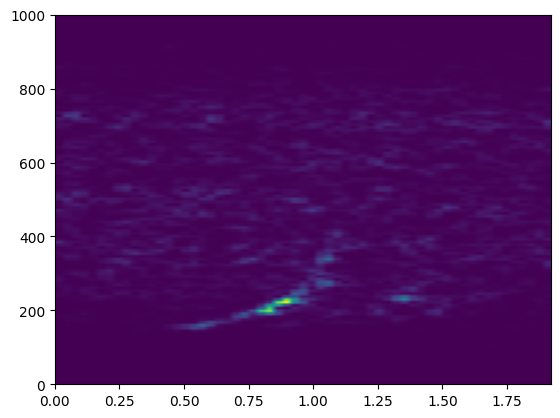

In [5]:
whale_strSig = whale_aiff.readframes(whale_aiff.getnframes())
whale_array = np.fromstring(whale_strSig, np.short).byteswap()
params = {'NFFT':256, 'Fs':2000, 'noverlap':192}
P, freqs, bins = mlab.specgram(whale_array, **params)
PlotSpecgram(P, freqs, bins)

Now we can plot and recognize others spectrograms and add a target for each of them

In [6]:
# Set path to directory with folders train and test
path_data = '../data/data/'
path_train_audio = '../data/data/train/'
path_target_train = '../data/data/train.csv'

In [ ]:
# ReadAIFF function
def ReadAIFF(file):
# Reads the frames from the audio clip and returns the uncompressed data
    s = aifc.open(file,'r')
    nFrames = s.getnframes()
    strSig = s.readframes(nFrames)
    return np.fromstring(strSig, np.short).byteswap()

In [60]:
# ReadAIFF function
def ReadAIFF(file):
# Reads the frames from the audio clip and returns the uncompressed data
    s = aifc.open(file,'r')
    nFrames = s.getnframes()
    strSig = s.readframes(nFrames)
    return np.fromstring(strSig, np.short).byteswap()

# Plot spectrogram function
def plot_spectrogram(filename, whale_flag):
# Plots a single spectrogram
    sound = ReadAIFF(filename)
    fig = plt.figure(figsize = (10,6))
    ax1 = fig.add_subplot(111)
    # Setting spectrogram parameters
    my_cmap = matplotlib.cm.get_cmap('hsv_r')
    params = {'NFFT':256, 'Fs':2000, 'noverlap':192, 'cmap' : my_cmap}
    plt.specgram(sound, **params)
    title0 = 'Spectrogram - Non-whale sound' if whale_flag == 0 else 'Spectrogram - Whale sound'
    ax1.set_title(title0, fontsize = 16)
    ax1.set_xlabel('Time (seconds)', fontsize = 12)
    ax1.set_ylabel('Frequency (Hz)', fontsize = 12)
    cbar = plt.colorbar()
    cbar.set_label('Amplitude', fontsize = 12)

# # Plot non-whale sound    
# plot_spectrogram(path_data + 'train/train1.aiff', 0)
# # Plot whale sound
# plot_spectrogram(path_data + 'train/train6.aiff', 1)

In [61]:
# Plot spectrograms side by side
def plot_sbs_spectrogram(filename_whale, filename_non_whale):
    whale = ReadAIFF(filename_whale)
    nonwhale = ReadAIFF(filename_non_whale)
    plt.figure(figsize = (14,4))
    ax1 = plt.subplot(121)
    my_cmap = matplotlib.cm.get_cmap('hsv_r')
    params = {'NFFT':256, 'Fs':2000, 'noverlap':192, 'cmap' : my_cmap}
    plt.specgram(whale, **params)
    ax1.set_title('Whale sound spectrogram', fontsize = 12)
    ax1.set_xlabel('Time (seconds)', fontsize = 12)
    ax1.set_ylabel('Frequency (Hz)', fontsize = 12)
    cbar = plt.colorbar()
    cbar.set_label('Amplitude', fontsize = 12)
    ax2 = plt.subplot(122)
    plt.specgram(nonwhale, **params)
    ax2.set_title('Non-whale sound spectrogram', fontsize = 12)
    ax2.set_xlabel('Time (seconds)', fontsize = 12)
    ax2.set_ylabel('Frequency (Hz)', fontsize = 12)
    cbar = plt.colorbar()
    cbar.set_label('Amplitude', fontsize = 12)
    plt.show()

# Compare several examples:
# plot_sbs_spectrogram(path_data + 'train/train6.aiff', path_data + 'train/train1.aiff')
# plot_sbs_spectrogram(path_data + 'train/train7.aiff', path_data + 'train/train2.aiff')
# plot_sbs_spectrogram(path_data + 'train/train9.aiff', path_data + 'train/train3.aiff')
# plot_sbs_spectrogram(path_data + 'train/train12.aiff', path_data + 'train/train4.aiff')

Create train dataset